>#                            Tarea 0   Máquinas de aprendizaje
>
>
> Integrantes: 
>              - Anibal Palomo         rol: 201373575-4
>              - Cristian Aguilar      rol: 201304741-6

>#  2. Job Salary Prediction
>
>En esta sección se ha decido trabajar solo con una porción de los datos pues existen algunas funciones que recorren el dataframe linealmente como word_extractor o new_words, lo que genera costos computacionales demasiado altos, esto hace que el conjunto de validación reduzca su tamaño proporcionalmente, se ha seleccionado que corresponda al 10% de los datos de entrada.
>
> a) Carge los datos *csv* de entrenamiento y cree un conjunto de validación con los últimos 10 mil datos en un dataframe de *pandas*. Describa los datos, apóyese de gráficos ¿Cuántos datos hay en cada conjunto?  

In [1]:
import pandas as pd
df = pd.read_csv("Train_rev1.csv")
df = df[:40000]
df_train = df.iloc[:-4000]
df_val = df.iloc[-4000:]
...#load other sets
df_train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


Las las columnas del dataset se describen como el "cargo", "descripción", "una localidad", "localidad normalizada", "el tipo de contrato", "tiempo del contrato", "compañia del aviso", "salario mostrado", "salario normalizado" y la "fuente de los datos".

A continuación se muestran las cantidades de datos para cada conjunto data frame

In [2]:
df.shape,  df_train.shape, df_val.shape

((40000, 12), (36000, 12), (4000, 12))

A continuación se presentan la forma en que se distribuyen las variables discretas mediante gráficos y datos descriptivos de las variables.

(array([3.4067e+04, 5.7780e+03, 1.3400e+02, 2.1000e+01]),
 array([     0.,  50000., 100000., 150000., 200000.]),
 <a list of 4 Patch objects>)

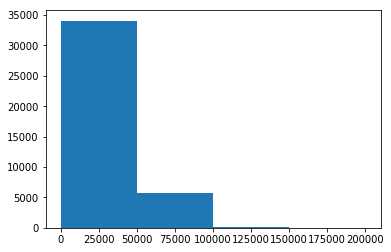

In [4]:
import matplotlib.pyplot as plt
data2 = df['SalaryNormalized']
maximo = df['SalaryNormalized'].max()
plt.hist(data2, 4, (0,maximo) )

El histograma para la distribución de salarios normalizados muestra que la mayor parte de los salarios estan entre 0 y 50.000, y aunque existen valores sobre los 150.000, son tan pocos en comparación que no se aprecian en el gráfico.

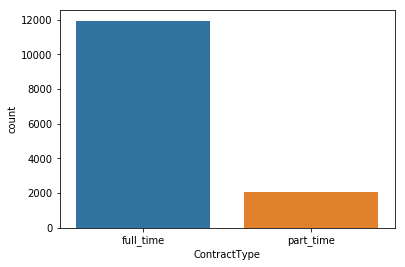

In [5]:
import seaborn as sns
%matplotlib inline
sns.countplot(x= "ContractType",data=df)

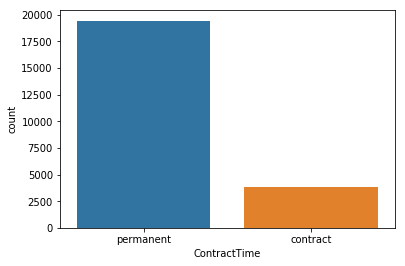

In [6]:
import seaborn as sns
%matplotlib inline
sns.countplot(x= "ContractTime",data=df)

Se observa que existe una mayor probabilidad que los contratos sean permanetes y tipos full-time.

Text(0.5,1,'Categorías de trabajos solicitados')

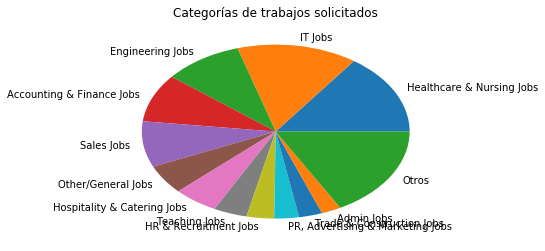

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.ion()  # Ponemos el modo interactivo

visitas = df['Category'].value_counts()[:12]
visitas = np.append(visitas,(df['Category'].value_counts()[12:]).sum())
paises = df['Category'].value_counts().keys()[:12]
paises = np.append(paises,"Otros")
plt.pie(visitas, labels = paises, )
plt.title("Categorías de trabajos solicitados")


Se observa que una gran parte de los trabajos estan concentrados en Informatica e Ingenería

El resto de las variables discretas como "LocationNormalized" tienen demasiados valores posibles por lo que un histograma no entregaría demasiada información  y resultaría engorroso, mientras que otras variables no normalizadas como "FullDescription" o "Title" llegaría incluso a ser improbable que se repitan los valores.

In [8]:
len(df['LocationRaw'].value_counts()),len(df['LocationNormalized'].value_counts()), len(df['Title'].value_counts()), len(df['FullDescription'].value_counts()), len(df['Company'].value_counts()) 

(6950, 1613, 29378, 39748, 7633)

Cantidad de: "Localidades", "localidades normalizadas", "títulos",  "Descripciones", "Compañias" distintas.

> b) Extraiga los datos de cada conjunto con los que trabajará, el input XX, los textos, y el output yy, los salarios.
    
> Se extraen los textos y los salarios correspondientes al entrenamiento y al conjunto de validación.

In [9]:
text_train = df_train.FullDescription
text_val = df_val.FullDescription
salary_train = df_train.SalaryNormalized
salary_val = df_val.SalaryNormalized

>Se utiliza la función word_extractor2 para pasar el texto de "full description" a un vocabulario éstandar, se seleccionó este extractor ya que genera un vocabulario que normaliza palabras similares lo que ayuda a relacionar entradas parecidas, a continuación se genera un vector características features_train.

In [10]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

def word_extractor2(text):
    wordstemmer = PorterStemmer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordstemmer.stem(word.lower())for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

#Se normalizan los textos usando word_extractor2
a = list()
for text in text_train:
    a.append(word_extractor2(text))
auxdf = pd.DataFrame()
auxdf['text'] = a

texts_train = auxdf['text']

b = list()
for text in text_val:
    b.append(word_extractor2(text))
auxdf2 = pd.DataFrame()
auxdf2['text'] = b

texts_val = auxdf2['text']

 > Se uso CounterVectorizer para contar la cantidad de veces que se repite cada palabra en el vocabulario de las palabras usadas.

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#Se transforman los textos normalizados a vectores usando CountVectorizer
vectorizer_train = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer_train.fit(np.asarray(texts_train))

X_train = vectorizer_train.transform(texts_train)
X_val = vectorizer_train.transform(texts_val)

#Se pasan las salidas Y a arreglo
Y_train = np.asarray(salary_train)
Y_val = np.asarray(salary_val)

X_train, X_val

(<36000x53388 sparse matrix of type '<class 'numpy.int64'>'
 	with 3695478 stored elements in Compressed Sparse Row format>,
 <4000x53388 sparse matrix of type '<class 'numpy.int64'>'
 	with 429210 stored elements in Compressed Sparse Row format>)

Tambien podemos observar la cabecera del vocabulario generado por los textos ya normalizados.

In [12]:
vocab = vectorizer_train.get_feature_names()
dist = list(np.array(X_train.sum(axis=0)).reshape(-1,))
lista = list(zip(vocab, dist))
lista.sort(key=lambda x: x[1],reverse=True)
lista_ordenada = lista
lista_ordenada[:10]

[('work', 29042),
 ('thi', 27093),
 ('experi', 27056),
 ('role', 21616),
 ('team', 20774),
 ('requir', 20020),
 ('manag', 19460),
 ('pleas', 18820),
 ('client', 18799),
 ('skill', 18421)]

> d) Intente resolver el problema enfrentándolo como regresión con el modelo de regresión lineal ordinaria en *sklearn*. ¿Qué es lo que hace *fit_intercept=True*? Evalúe la función objetivo (F.O.) utilizada y la métrica de la competencia (*mean absolute error*) en ambos conjuntos generados en el punto a). Comente lo observado.

> Se usa un modelo de regresión lineal ajustándolo a los datos de entrenamiento, donde X_train a sido previamente vectorizado ajustandose a un vocabulario común, lo que tambien se aplica a los datos de evaluación X_val.

> La variable fit_intercep le dice al modelo si es que quiere que los datos se ajusten considerando el intercepto, es decir, en términos de regresión lineal si se deben ajustar a alpha, con épsilon el ruido y beta una característica.

$$Y = {\beta}X + {\alpha} + {\epsilon}$$

In [13]:
from sklearn.linear_model import LinearRegression as LR
model = LR(fit_intercept=True, normalize=False)
model.fit(X_train, Y_train)
... #measure F.O.
from sklearn.metrics import mean_absolute_error #measure MAE


In [14]:
print("Accuracy under training: ",model.score(X_train,Y_train))
print("Accuracy under validation: ",model.score(X_val,Y_val))

Accuracy under training:  0.9749711626937408
Accuracy under validation:  -11.865878019546555


In [15]:
print("MAE on train: ",mean_absolute_error(Y_train, model.predict(X_train)))
print("MAE on validation: ",mean_absolute_error(Y_val, model.predict(X_val)))

MAE on train:  1204.1345019564142
MAE on validation:  39569.04640388329


> Los valores obtenidos para los datos de entrenamiento son buenos (menores a 3400) por que el modelo esta ajustado a esos datos, por lo que la predicción es similar a la salida real, no obstante para nuevos datos X_val la diferencia es mucho mayor por lo que este modelo se considera sobre ajustado a los datos.

> e) Intente mejorar sus resultados en base a la métrica de la competencia (MAE) sobre el conjunto de validación. Comente sobre lo realizado.  

> Se crea una función que genera un nuevo texto considerando solo la información relevante que esta representada en las demás columnas, por lo que se descarta la columna FullDescription, así el nuevo texto se representará como :
   
  > ( "Location" "Company" "Category" "ContractType" "ContractTyme" "Title")

In [16]:
def new_words(df_train):
    feature_train = pd.DataFrame()    
    feature_train["LocationNormalized"] = df_train["LocationNormalized"]
    feature_train["Company"] = df_train["Company"]
    feature_train["Category"] = df_train["Category"]
    feature_train["ContractType"] = df_train["ContractType"]
    feature_train["ContractTime"] = df_train["ContractTime"]
    feature_train["Title"] = df_train["Title"]
    a = list()
    
    for row in feature_train.values:        
        location  = str(row[0])
        company = str(row[1])
        category = str(row[2])
        contracttype = str(row[3])
        contracttime = str(row[4]) 
        title = str(row[5])
        texto = location+" "+company+" "+category+" "+contracttype+" "+contracttime+" "+title    
        a.append(texto)

    feature_train['NewText'] = a  
    return feature_train['NewText']

> La función entrega un vector de textos para entrenamiento y validación, con el primero se utiliza CountVectorizer para crear un vector en base al diccionario de palabras que resulta mucho menor ya que no considera palabras que no aportaban al aprendizaje contenidas en la columna "FullDescription".

In [17]:
texts_train2 = new_words(df_train)
texts_val2 = new_words(df_val)

vectorizer_train2 = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer_train2.fit(np.asarray(texts_train2))

X_train2 = vectorizer_train2.transform(texts_train2)
X_val2 = vectorizer_train2.transform(texts_val2)

#Se pasan las salidas Y a arreglo
Y_train2 = np.asarray(salary_train)
Y_val2 = np.asarray(salary_val)

X_train2, X_val2

(<36000x12251 sparse matrix of type '<class 'numpy.int64'>'
 	with 392896 stored elements in Compressed Sparse Row format>,
 <4000x12251 sparse matrix of type '<class 'numpy.int64'>'
 	with 44170 stored elements in Compressed Sparse Row format>)

> Se observa que el número de dimensiones de los vectores se reducen en comparación al modelo anterior y el valor entregado es más relevante para el learner.

In [18]:
model2 = LR(fit_intercept=True, normalize=False)
model2.fit(X_train2, Y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
print("MAE on train: ",mean_absolute_error(Y_train2, model2.predict(X_train2)))
print("MAE on validation: ",mean_absolute_error(Y_val2, model2.predict(X_val2)))

MAE on train:  5380.662238656434
MAE on validation:  9790.683770948193


> Los valores obtenidos para el MAE son mucho menores en comparación en ambos casos, por lo que se reduce el sobreajuste anterior al considerar características relevantes.

> #  Conclusiones de esta sección
>
> Para la regresión lineal estamos utilizando muchas características para poder predecir un valor exacto Y donde cada una tiene una relevación que se asocia al valor final obtenido. Uno de los trabajos más importantes que se deben realizar para mejorar las respuestas del learner, es la correcta selección de las variables y esto implica poder reconocer aquellas que aportan contenido y pueden generar una reacción en la variable de salida, y aquellas que no se relacionas y son redundantes, por lo que se deben quitar yaque se podría "mal enseñar" al learner ajustandolo a contenido que no se relaciona con la salida.

----------------------------------------------------------------------------------------------------------------------------

## 3. Linear Regression by hand

> a) Escriba una función que calcule la función de pérdida, error cuadrático medio (MSE - *mean squared error*), para un dato o para un conjunto de datos.

Para simplificar los calculos se utilizará la versión matricial de las variables:

Para quitar la sumatoria, el problema se puede escribir de manera matricial definiendo las siguientes matrices:
* Las respuestas deseadas se organizan como filas de una matriz $Y$ de dimensiones n x 1.
* Las incognitas $\beta_0,\beta_1,\beta_2$ se organizan en un vector $\vec{\beta}$ de dimension d+1.
* Los ejemplos de entrada se organizan como una matriz $X$ de dimensiones n x d+1.

Entonces la regresión lineal se puede escribir de la siguiente manera:

$$
    \hat{Y} = X*\vec{\beta}
$$

Y la ecuación de perdida se puede escribir como:

$$
    Loss = \frac{1}{N}||Y-\hat{Y}||^2
$$

Donde N es la cantidad de outputs (cantidad de valores en Y).

In [88]:
import numpy as np

def reg(input_values,betas): 
    return np.dot(input_values,betas)

def MSE(input_values,output,betas,uno = False):
    predicted_values = reg(input_values,betas)
    if (uno):
        N = 1
    else:
        N = len(output)
    return(1/N)*np.linalg.norm(output - predicted_values)**2

> b) Escriba una función que calcule el gradiente (derivada) de la función de pérdida anterior, para un dato o para un conjunto de datos. *Escriba explícitamente la derivada (gradiente)*.

En forma matricial:

Utilizando las formas matriciales de la parte a), el gradiente será:

$$
    \nabla_{\vec{\beta}}Loss =\frac{1}{N} \nabla_{\vec{\beta}}||Y-\hat{Y}||^2   
$$

$$
    \nabla_{\vec{\beta}}||Y-\hat{Y}||^2 = 2X^T(X\vec{\beta} - Y)     
$$

Reemplazando:

$$
    \nabla_{\vec{\beta}}Loss = \frac{1}{N} 2X^T(X\vec{\beta} - Y)
$$

In [2]:
def MSEgradient(X,Y,beta,uno = False): #X dim n x d+1, Y dim n x 1, beta es un vector, es decir dim d+1 x 1. 
    if (uno):
        N = 1
    else:
        N = len(Y)
    return (2/N)*np.dot(np.transpose(X),(np.dot(X,beta) - Y))

> c) Escriba una función que calcule los parámetros de una regresión lineal simple de manera analítica (es decir el mínimo global). 

Igualando a 0 la funcion del gradiente de la función de pérdida obtenida en b):

$$
    \nabla_{\vec{\beta}}Loss = \frac{1}{N} 2X^T(X\vec{\beta} - Y) = 0
$$

Se obtiene el siguiente valor de $\beta$:
$$
    \vec{\beta} = (X^TX)^{-1}X^{T}Y 
$$


In [3]:
def calcular_betas(X,Y):
    return(np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),Y))

> d) Ahora escriba un programa que permita entrenar una regresión lineal a través del algoritmo SGD mostrado en la ecuación del algoritmo SGD, es decir, que de manera iterativa, vaya tomando un dato a la vez, y actualizando el parámetro $\beta$ a través del gradiente descendiente de la función de pérdida de la regresión lineal ordinaria, de la pregunta b).

Reemplazando el valor del gradiente de la función de perdida en la ecuación del algoritmo SGD:

$$ \vec{\beta}^{(t+1)} \leftarrow \vec{\beta}^{(t)} - \eta \frac{1}{N} 2X^T(X\vec{\beta} - Y) $$

In [89]:
import random as rd

def SGD(X,Y,initial_betas,learning_rate, iteraciones = 1): #se actualiza beta despues de revisar el dataset completo
    betas = initial_betas    
    MSEs = []
    for i in range(iteraciones):
        betas -= learning_rate*MSEgradient(X,Y,betas)
        MSEs.append(MSE(X,Y,betas))
    return MSEs

def SGDvector(X,Y,initial_betas,learning_rate, iteraciones = 1): #se actualiza beta en cada dato del dataset
    betas = initial_betas    
    MSEs = []
    for i in range(iteraciones):
        for x,y in list(zip(X,Y)):
            betas -= learning_rate*MSEgradient(x,y,betas,uno = True)
            MSEs.append(MSE(x,y,betas,uno = True))
    return MSEs

Se probaron dos formas de SGD, uno que actualiza los betas por cada dato del dataset (SGDvector) y uno que actualiza los betas despues de ver el dataset completo (SGD).

> e) Demuestre que sus programas funcionan en un problema de regresión simple. Para esto utilice el dataset **Boston Housing** , disponible a través de la librería __[*sklearn*](http://scikit-learn.org)__, el cual corresponde a el precio de diferentes casas en Boston además de distintas características relevantes respecto al lugar, como por ejemplo el crimen en la ciudad, el número de habitaciones, que tan vieja es, distancia a lugares relevantes, entre otros. Éstas características deben combinarse linealmente para estimar el precio de la casa.
<div class="alert alert-block alert-info">Es una buena práctica el normalizar los datos antes de trabajar con el modelo</div>

Primero se describirá el dataset:

In [5]:
from sklearn.datasets import load_boston
import sklearn as skl

#Descripcion del dataset:
boston = load_boston()
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Entonces una instancia corresponde a los primeros 13 atributos como el vector $\vec{x}$, mientras que el atributo 14 (MEDV) corresponde a $y$, el atributo CHAS solo toma valores de 0 o 1. 

In [113]:
import random
X_train,y_train = load_boston(return_X_y=True)
scaler = skl.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
initial_betas = random.sample(range(1, 100), 13) #13 betas iniciales con valores de rango entre 1 y 100
initial_betas 

[80, 40, 55, 42, 1, 64, 20, 32, 41, 43, 48, 67, 16]

La funcion load_boston con el parámetro return_X_y = True, toma los vectores $\vec{x}$ y valores $y$ (explicados anteriormente) del dataset y los guarda en las variables X_train, y_train. 

La función para normalizar los datos es StandardScaler y luego transform, esto transforma los datos de manera que su distribución tenga una media de 0 y una desviación estándar de 1, es decir como una distribución normal, esto con el fin de mejorar el aprendizaje de la maquina.

Los betas iniciales utilizados deben ser un vector del mismo tamaño que $\vec{x}$ y se eligen generalmente al azar, en este caso son trece enteros entre 1 y 100.

> Para evaluar los resultados, construya un gráfico correspondiente a la función de pérdida utilizada en el entrenamiento *versus* número de iteraciones (**realice 1000 iteraciones**), utilizando sólo el conjunto de entrenamiento (el objetivo de esta sección es familiarizarse con el algoritmo). Además de reportar el tiempo de entrenamiento mediante el algoritmo implementado en c) y d).

In [118]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def aux(training_rate):
    errores = SGDvector(X_train,y_train,initial_betas,training_rate,2)
    plt.plot(errores)
    plt.xlabel("Iteraciones")
    plt.ylabel("MSE")
    plt.title("Entrenamiento")
    plt.show()
    return

#Widget 1
interact(aux,training_rate = widgets.FloatSlider(min = 0.0, max = 0.1, step = 0.005,value = 0.01))

interactive(children=(FloatSlider(value=0.01, description='training_rate', max=0.1, step=0.005), Output()), _dom_classes=('widget-interact',))

<function __main__.aux>

In [117]:
def aux2(training_rate):
    errores2 = SGD(X_train,y_train,initial_betas,training_rate,1000)
    plt.plot(errores2)
    plt.xlabel("Iteraciones")
    plt.ylabel("MSE")
    plt.title("Entrenamiento")
    plt.show()
    print(errores2[len(errores2)-1])
    return

#Widget 2
interact(aux2,training_rate = widgets.FloatSlider(min = 0.0, max = 1, step = 0.01,value = 0.01))

interactive(children=(FloatSlider(value=0.01, description='training_rate', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.aux2>

Se itero 2 veces sobre el dataset completo con SGDvector, es decir 1012 iteraciones actualizando beta en cada instancia (widget 1), tambien se itero 1000 veces sobre el dataset completo actualizando beta en cada iteración (widget 2).

In [106]:
#Tiempos:

import timeit

#SGD
start = timeit.default_timer()
errores = SGDvector(X_train,y_train,initial_betas,0.035,2)
stop = timeit.default_timer()
print('Tiempo de ejecución SGD: ', stop - start) 

#Inversa
start = timeit.default_timer()

bet = calcular_betas(X_train,y_train)
stop = timeit.default_timer()
print('Tiempo de ejecución usando el método teórico: ', stop - start) 

Tiempo de ejecución SGD:  0.036710336282339995
Tiempo de ejecución usando el método teórico:  0.0015190281746981782


El tiempo de ejecución de SGDvector es mayor probablemente debido al número de iteraciones para reducir el MSE (probablemente es necesario mayor cantidad de iteraciones para llegar al mínimo global) mientras que usando el método teórico basta con hacer algunas operaciones con matrices para llegar al mínimo, aunque el método teórico pareciera ser mejor en cuanto a eficiencia, no hay que olvidar el hecho de que la regresión lineal utilizada tiene un óptimo derivable analíticamente, por lo tanto el método teórico tiene restricciones que el método SGD no posee, sin considerar que al obtener el mínimo analíticamente aparece una matriz inversa, la operación de obtener la inversa es costosa, por lo que puede que para este caso de un dataset pequeño (506 instancias) la opción de obtener el mínimo teóricamente es viable.

> f) Varié la tasa de aprendizaje $\eta \in [0,1]$ del algoritmo SGD del punto d), compare los resultados entre sí y con la solución óptima encontrada en c). Comente.

In [115]:
MSEteo = MSE(X_train,y_train,calcular_betas(X_train,y_train))
MSEsgd = SGD(X_train,y_train,initial_betas,0.16,1000)
print("MSE método teórico: " + str(MSEteo)) #error del método teórico
print("MSE método SGD: " + str(MSEsgd[len(MSEsgd) - 1]))
print("Diferencia teo vs SGD:" + str(MSEteo - MSEsgd[len(MSEsgd) - 1]))

MSE método teórico: 529.6251400575699
MSE método SGD: 529.6251400575699
Diferencia teo vs SGD:0.0


Al comparar el error obtenido con ambos métodos se obtiene que el error usando SGD es casi igual al método teórico, esto ocurre probablemente debido a que se escogió correctamente el learning_rate para el cálculo además de un número de iteraciones adecuado, además hay que mencionar que no se comparó usando SGDvector debido a que el mínimo teórico se obtuvo viendo el problema como matrices, no como vectores. 

Con el widget 1 se puede ver como la máquina va "aprendiendo", es decir la cantidad de error se mantiene más cercana a 0 a medida que se aumenta $\eta$, pero solo hasta cierto rango (aprox 0.01 da los menores errores en general). 

Usando el widget 2 se puede apreciar como el valor $\eta$ afecta el comportamiento de la convergencia del algoritmo SGD, cuando este toma valores pequeños (0 a 0.16 aprox), el MSE converge al error obtenido a través de la forma analítica, pero cuando se sale de ese rango el MSE no converge y aumenta de manera desmesurada.